<a href="https://colab.research.google.com/github/hatopopvr/MyBSCloud/blob/main/MyBSCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MyBSCloud

<b>概要</b>
- ScoreSaberのデータを使用して自分のプレイを構成するマッパーや作曲者のwordcloud画像を作成するツールです。
- マスク画像を使用することで自分らしいwordcloud画像を作成することもできます。
- Google Driveの認証はScoreSaberのプレイデータを保存することのみに使います。(アクセス負荷減
- ※日本語には対応していません

<b>データ元</b>
- Score Data from ScoreSaber Public API - [doc](https://docs.scoresaber.com/)  

<b>作者</b>
- hatopop ([@hatopop_vr](https://twitter.com/hatopop_vr))

<b>お願い</b>
- 気に入ったらgithubのstarをお願いします。

In [1]:
#@title ※※※ 入力情報 ※※※

#@markdown 以下のデータを入力してください。 { display-mode: "form" }

#@markdown ---
#@markdown <h4>Input Data</h4>

#@markdown <font size="2">`player_id` : ScoreSaberのPlayerIDです。変更必須。<br/></font>  
player_id =  76561198412839195#@param {type:"number"}

#@markdown <font size="2">`google_drive_mount_path` ：GoogleDriveのマウント先です。変更不要。</font><br/> 
google_drive_mount_path = "/content/drive" #@param {type:"string"}

#@markdown <font size="2">`google_drive_dir_path` : GoogleDrive内の保存先です。必要に応じて変更してください。</font> 
google_drive_dir_path = "/MyDrive/MyBeatSaberAnalysis/data" #@param {type:"string"}

#@markdown ---
#@markdown <h4>Setting</h4>

#@markdown <font size="2">`saved_song_list_is_enable`:保存済の曲情報を使用するか。☑で使用。</font> 
saved_song_list_is_enable = True #@param {type:"boolean"}
#@markdown <font size="2">`saved_player_score_is_enable`: 保存済のプレイ情報を使用するか。☑で使用。※差分ダウンロード。</font>
saved_player_score_is_enable = True #@param {type:"boolean"}
# #@markdown <font size="2">`acc_recalq_override_is_enable`: MaxScore,Accを再計算した値をMaxScore,Accに上書きするか。☑で使用。</font> 
# acc_recalq_override_is_enable = True #@param {type:"boolean"}
# #@markdown <font size="2">`beatleader_data_is_enable`: BeatLeaderのデータを取得するか。L/RのAccやReplayのリンクなど追加。☑で使用。</font> 
# beatleader_data_is_enable = True #@param {type:"boolean"}
# #@markdown <font size="2">`ranked_song_from_leaderboard_is_enable`: Ranked譜面クリア進捗用のレベル別譜面数をScoreSaberのLeaderBoardから取得し直すか。☑で使用。<br /></font>
# #@markdown <font size="2">※Ranked譜面の譜面数が正しく得られていない時のみ取得し直されます。</font>
# ranked_song_from_leaderboard_is_enable = True #@param {type:"boolean"}
#markdown <font size="2">`ss_plus_is_enable`: AccRank区分にSS+を使用するか。☑で使用。  </font><br /> 
ss_plus_is_enable = True #param {type:"boolean"}
#markdown <font size="2">`ss_plus_val`:SS+の設定値です。必要に応じて変更ください。範囲は91-99。  
ss_plus_val = 95 #param {type:"slider", min:91, max:99, step:1}
#@markdown <font size="2">`latest`:直近の成果として扱う対象の日数です。0は日本時間で今日と同じ日付。例)今日が5/9で1なら5/8以降のデータ。</font><br /> 
#@markdown <font size="2">※名称がlatestだったりRecentだったり混在してしまっていますが許してください。</font>
latest =  0#@param {type:"integer"}
#markdown <font size="2">`score_mode`:取得するスコアを選択します。`HigherScore`は`BaseScore`と`ModifieredScore`の高い方の値を採用します.</font>
score_mode = "HigherScore" #param ["BaseScore", "ModifieredScore", "HigherScore"]

# ------------------------
#@title Libraryの取得
# ------------------------
#markdown - Libraryの取得<br >
#markdown - timezoneの設定 (UTC->日本時間 Asia/Tokyo+9:00 ,tz_ja)
#markdown - google driveのマウント<br >

!pip install GitPython

import warnings
warnings.filterwarnings("ignore")
import os
import shutil
import pandas as pd
from pandas import json_normalize
import json
from datetime import datetime, timedelta
from dateutil import tz
#import matplotlib
#import seaborn as sns
import plotly.express as px
from ipywidgets import interact, Select, BoundedIntText, IntSlider, ToggleButtons, Layout, HBox, VBox, AppLayout
import time
from tqdm import tqdm
import requests
import math
import git
import gc
from IPython.display import HTML, Javascript,Image
from google.colab import drive, files
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import copy

try:
    from wordcloud import WordCloud, STOPWORDS
    import stylecloud
except ImportError:
    !pip install japanize-matplotlib
    !pip install stylecloud
    from wordcloud import WordCloud, STOPWORDS
    import stylecloud

#-------------------------------
#@title Timezoneの変更
#-------------------------------
tz_ja = pd.Timestamp(datetime.now()).tz_localize('UTC').tz_convert('Asia/Tokyo')
#today_tz_ja = datetime_now_tz_ja.strftime("%Y.%m.%d")
print("取得日時:{}".format(tz_ja))

#-------------------------------
#@title Google Driveのマウント
#-------------------------------
drive.mount(google_drive_mount_path)

#-------------------------------
#@title 内部設定値
#-------------------------------
# データ元のURL
## song_data_zip_git_url: ScoreSaberの全曲情報のzip(json)のURLです。変更なければそのままで。 
song_data_zip_git_url = "https://github.com/andruzzzhka/BeatSaberScrappedData.git"
## ranked_excluded_data_git_url: ScoreSaberのRank譜面除外リスト(csv)のURLです。暫定的処置。 
ranked_excluded_data_git_url = "https://github.com/hatopopvr/ScoreSaberRankedExcludedMaps.git"
## rankedmapdata_url: BeatSaverデータのcsvのURLです。らっきょさんデータ。 
rankedmapdata_url = 'https://api.github.com/repos/rakkyo150/RankedMapData/releases'
# google drive内のdata置き場親フォルダ
data_path = r"{}{}".format(google_drive_mount_path, google_drive_dir_path)
# player情報の親フォルダ(data_pathの子フォルダ)
player_path = r"{}/players_data/{}".format(data_path, player_id)
## playerinfoの保存先
player_info_path = r"{}/player_info_{}.csv".format(player_path, player_id)
## playerのscore関連保存先
player_score_path = r"{}/scores_full_{}.csv".format(player_path, player_id)
player_ranked_path = r"{}/scores_ranked_{}.csv".format(player_path, player_id)
## playerのscore関連保存先
player_score_pickle_path = r"{}/scores_full_{}.pkl".format(player_path, player_id)
player_ranked_pickle_path = r"{}/scores_ranked_{}.pkl".format(player_path, player_id)
## 曲情報の保存関連
song_clone_path = r"/content/BeatSaberScrappedData"
song_zip_path = r"{}/combinedScrappedData.zip".format(song_clone_path)
song_json_path = r"{}/combinedScrappedData.json".format(data_path)
song_pickle_path = r"{}/combinedScrappedData.pkl".format(data_path)
## 曲情報の保存先
song_list_path = r"{}/song_list_full.csv".format(data_path)
song_ranked_path = r"{}/song_ranked.csv".format(data_path)

# song_playlist_path = r"{}/playlist_{}.json".format(data_path, datetime.now().strftime("%Y%m%d"))
# ランク除外関連パス
ranked_excluded_clone_dir_path = r"/content/ScoreSaberRankedExcludedMaps"
ranked_excluded_clone_csv_path = r"{}/RankedExcludedMaps.csv".format(ranked_excluded_clone_dir_path)
ranked_excluded_csv_path = r"{}/RankedExcludedMaps.csv".format(data_path)
# levelclearランク除外関連パス
#level_cleared_path = r"{}/level_cleared_{}.csv".format(data_path, player_id)
level_cleared_path = r"{}/level_cleared_{}.csv".format(player_path, player_id)

# playlistの保存
song_playlist_path = r"{}/playlists".format(data_path)
song_worst_playlist_path = r"{}/worst_playlist_{}.json".format(song_playlist_path, tz_ja.strftime("%Y%m%d"))
song_top_playlist_path = r"{}/top_playlist_{}.json".format(song_playlist_path, tz_ja.strftime("%Y%m%d"))

# # MｙBSCloudのmask画像の保存
# # player情報の親フォルダ(data_pathの子フォルダ)
# mybscloud_path = r"{}/mybscloud/{}".format(data_path, player_id)

# SS_plus設定値
ss_plus = "SS+{}".format(ss_plus_val)
ss_plus_rate = "SS+{}-Rate".format(ss_plus_val)
# その他 colab表示など設定
pd.options.display.precision = 2
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
page_count=100 #ScoreSaberの1ページあたりのページ数

# 出力最大高さ
def resize_colab_cell():
    display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))

get_ipython().events.register('pre_run_cell', resize_colab_cell)

#-------------------------------
#@title 列情報の設定
#-------------------------------
# Player Infoの記録用列 (TotalFC, RankedFCは別途結合)
cols_info =[
    "Pic"
    ,"name"
    ,"country"
    ,"pp"
    ,"rank"
    ,"countryRank"
    ,"role"
    ,"TotalScore"
    ,"RankedScore"
    ,"AveRankedAcc"
    ,"TotalPlay"
    ,"RankedPlay"
    ,"ReplayWatched"
    ,"ScoreDate"
    ,"TotalFC"
    ,"RankedFC"
    ,"TotalPlayRank"
    ,"TotalPlayJPRank" 
    ,"RankedPlayRank"
    ,"RankedPlayJPRank"
    ,"TotalScoreRank" 
    ,"TotalScoreJPRank"
    ,"RankedScoreRank"
    ,"RankedScoreJPRank" 
    ,"AveRankedAccRank"
    ,"AveRankedAccJPRank"
]

# Player Infoの表示用列 (TotalFC, RankedFCは別途結合)
cols_info_sort =[
    "Pic"
    ,"name"
    ,"country"
    ,"pp"
    ,"rank"
    ,"countryRank"
    ,"role"
    ,"TotalScore"
    ,"RankedScore"
    ,"AveRankedAcc"
    ,"TotalPlay"
    ,"RankedPlay"
    ,"TotalFC"
    ,"RankedFC"
    ,"ReplayWatched"
    ,"ScoreDateJa"
]

# リュナンさんのScoreSaberRanking表示用列(不使用)
cols_info_rank = [
    "TotalPlayRank"
    ,"TotalPlayJPRank" 
    ,"RankedPlayRank"
    ,"RankedPlayJPRank"
    ,"TotalScoreRank" 
    ,"TotalScoreJPRank"
    ,"RankedScoreRank"
    ,"RankedScoreJPRank" 
    ,"AveRankedAccRank"
    ,"AveRankedAccJPRank"
]

# summary用列
cols_summary =[
    "rank"
    ,"countryRank"
    ,"pp"
    ,"AveRankedAcc"
    ,"TotalPlay"
    ,"RankedPlay"
]

# SongList抜粋用列
cols_song =[
    "Cover"
    ,"Song"
    ,"Level"
    ,"LevelStr"
    ,"Stars"
    # ,"maxPP"
    # ,"maxScore"
    ,"Difficulty"
    # ,"Play"
    # ,"DailyPlay"
    ,"CreatedDateJa"
    ,"RankDateJa"
    ,"Bombs"
    ,"Notes"
    ,"Obstacles"
    ,"Njs"
    ,"NjsOffset"
    ,"Bpm"
    ,"Upvotes"
    #,"Downvotes"
    ,"Duration"
    ,"Ranked"
]

# Rank譜面除外リスト結合用列
cols_excluded = [
                 'Hash',
                 'Difficulty',
                 'RankedExcluded'
                 ]

# Score用列
cols_score =[
    "Cover"
    ,"Song"
    ,"Level"
    ,"Stars"
    ,"Acc"
    ,"AccRank"
    ,"FC"
    ,"Rank"
    ,"PP"
    ,"Miss"
    ,"Bad"
    ,"Combo"
    ,"Score"
    #,"Mode"
    ,"Difficulty"
    ,"Play"
    ,"DailyPlay"
    ,"Bpm"
    ,"Duration"
    ,"Notes"
    ,'Nps'
    ,"Njs"
    ,"Bombs"
    ,"Obstacles"
    ,"NjsOffset"
    ,'Upvotesratio' 
    ,"Upvotes"
    ,"Downvotes"
    ,"Ranked"
    ,"Days"
    ,"Months"
    ,"Tags"
    ,"Preview"
 ]

# Acc再計算用列
cols_recalq = [
    'Hash',
    'Cover',
    'SongName',
    'Difficulty', 'Stars', 
    'Ranked', 
    'Notes', 
    'Acc', 
    'AccRecalq', 
    'AccDiff',
    'AccRank', 
    'AccRankRecalq', 
    'MaxScore',
    'MaxScoreRecalq',
    'MaxScoreDiff',
    'Score', 
    'Miss', 
    'Combo',
    'RankDateJa',
    'CreatedDateJa', 
    'Preview'
]

# ScatterPlot用X-Y軸列
cols_xy = [
    "Stars"
    ,"Level"
    ,"Acc"
    ,"Rank"
    ,"PP"
    ,"Miss"
    ,"Bad"
    ,"Combo"
    ,"Score"
    ,"Play"
    ,"DailyPlay"
    ,"Days"
    ,"Months"
    ,"Bpm"
    ,"Duration"
    ,"Notes"
    ,'Nps'
    ,"Njs"
    ,"Bombs"
    ,"Obstacles"
    ,"NjsOffset"
    ,'Upvotesratio'
    ,"Upvotes"
    ,"Downvotes"
]

# RankedMap(BeatSaver)結合用列
cols_rankedmap = ['Hash', 
                  'Difficulty', 
                  'Upvotesratio',
                  'Nps', 
                  'Tags', 'Preview'
]

# ScatterPlot用カテゴリ
cols_cate = [
    "LevelStr"
    ,"Days"
    ,"DaysStr"
    ,"Months"
    ,"MonthsStr"
    ,"LatestStr"
    ,"Acc"
    ,"AccRank"
    ,"FC"
    ,"SongAuthor"
    ,"LevelAuthor"
]

# Worst-Top ScatterPlot用カテゴリ
cols_cate_wt = [
    "WorstTop"
    ,"LevelStr"
    ,"Days"
    ,"DaysStr"
    ,"Months"
    ,"MonthsStr"
    ,"LatestStr"
    ,"Acc"
    ,"AccRank"
    ,"FC"
    ,"SongAuthor"
    ,"LevelAuthor"
]

# Latest_history用の列
cols_latest_history = ['Cover', 'Song', 'Difficulty', 'Stars', 'Acc', 'AccRank', 'FC', 'Rank', 'PP',
       'Miss', 'Bad', 'Combo', 'Score']

#-------------------------------
#@title スタイルの設定
#-------------------------------

cover_image_size=70 #カバー,プロファイル画像のサイズ単位px
info_image_size=150 #Player画像のサイズ単位px

style_format = {
        "rank": "#{:,.0f}",
        "countryRank": "#{:,.0f}",
        "TotalScore": "{:,.0f}",
        "RankedScore": "{:,.0f}",
        "AveRankedAcc": "{:,.2f}%",
        "TotalPlay": "{:,.0f}",
        "TotalFC": "{:,.0f}",
        "RankedFC": "{:,.0f}",
        "ReplayWatched": "{:,.0f}",
        "Level": "{:,.0f}",
        "Stars": "{:,.2f}★",
        "Acc": "{:,.2f}%",
        "AccRecalq": "{:,.2f}%",
        "AccDiff": "{:,.2f}%",
        "MaxScore": "{:,.0f}",
        "MaxScoreRecalq": "{:,.0f}",
        "MaxScoreDiff": "{:,.0f}",
        "Score": "{:,.0f}",
        "Rank": "#{:,.0f}",
        "pp": "{:,.2f}pp",
        "PP": "{:,.2f}pp",
        "Miss": "{:,.0f}",
        "Bad": "{:,.0f}",
        "Combo": "{:,.0f}",
        "Score": "{:,.0f}",
        "Play": "{:,.0f}",
        "DailyPlay": "{:,.0f}",
        "Bpm": "{:,.0f}",
        "Duration": "{:,.0f}",
        "Notes": "{:,.0f}",
        "Nps": "{:,.2f}",
        "Njs": "{:,.0f}",
        "Bombs": "{:,.0f}",
        "Obstacles": "{:,.0f}",
        "NjsOffset": "{:,.2f}",
        "Upvotesratio": "{:,.2f}",
        "Upvotes": "{:,.0f}",
        "Downvotes": "{:,.0f}",
        "Days": "{:,.0f}",
        "Months": "{:,.0f}",
        "Song": "{:,.0f}",
        "RecentCleared": "{:,.0f}",
        "Cleared": "{:,.0f}",
        "NF": "{:,.0f}",
        "NotCleared": "{:,.0f}",
        "AlreadyCleared": "{:,.0f}",
        "NotClearedRate": "{:,.2f}%",
        "AlreadyClearedRate": "{:,.2f}%",
        "RecentClearedRate": "{:,.2f}%",
        "NFRate": "{:,.2f}%",
        "SSS": "{:,.0f}",
        ss_plus: "{:,.0f}",
        "SS": "{:,.0f}",
        "S": "{:,.0f}",
        "A": "{:,.0f}",
        "B": "{:,.0f}",
        "Other": "{:,.0f}",
        "SSS-Rate": "{:,.2f}%",
        "SS-Rate": "{:,.2f}%",
        ss_plus_rate: "{:,.2f}%",
        "S-Rate": "{:,.2f}%",
        "A-Rate": "{:,.2f}%",
        "B-Rate": "{:,.2f}%",
        "Other-Rate": "{:,.2f}%",
        "FC": "{:,.0f}",
        "RecentFC": "{:,.0f}",
        "AlreadyFC": "{:,.0f}",
        "NotFC": "{:,.0f}",
        "AlreadyFCRate": "{:,.2f}%",
        "RecentFCRate": "{:,.2f}%",
        "NotFCRate": "{:,.2f}%",
        "Song": "{:,.0f}",
        "TotalPlayRank": "#{:,.0f}",
        "TotalPlayJPRank": "#{:,.0f}",
        "RankedPlayRank": "#{:,.0f}",
        "RankedPlayJPRank": "#{:,.0f}",
        "TotalScoreRank": "#{:,.0f}",
        "TotalScoreJPRank": "#{:,.0f}",
        "RankedScoreRank": "#{:,.0f}",
        "RankedScoreJPRank": "#{:,.0f}",
        "AveRankedAccRank": "#{:,.0f}",
        "AveRankedAccJPRank": "#{:,.0f}",
     }

ss_plus = "SS+{}".format(ss_plus_val)
ss_plus_rate = "SS+{}-Rate".format(ss_plus_val)

style_worst_top = {
        "Level": "{:,.0f}",
        "Stars": "{:,.2f}★",
        "Acc": "{:,.2f}%",
        "Rank": "#{:,.0f}",
        "pp": "{:,.2f}pp",
        "PP": "{:,.2f}pp",
        "Miss": "{:,.0f}",
        "Bad": "{:,.0f}",
        "Combo": "{:,.0f}",
        "Score": "{:,.0f}",
        "Play": "{:,.0f}",
        "DailyPlay": "{:,.0f}",
        "Bpm": "{:,.0f}",
        "Duration": "{:,.0f}",
        "Notes": "{:,.0f}",
        "Nps": "{:,.2f}",
        "Njs": "{:,.0f}",
        "Bombs": "{:,.0f}",
        "Obstacles": "{:,.0f}",
        "NjsOffset": "{:,.2f}",
        "Upvotesratio": "{:,.2f}",
        "Upvotes": "{:,.0f}",
        "Downvotes": "{:,.0f}",
        "Days": "{:,.0f}",
        "Months": "{:,.0f}",
     }

def color_negative_red(val):
    color = 'red' if val < 0 else 'blue'
    return 'color: %s' % color

# Difficulty color
def color_difficulty(val):
    if val == "Easy":
        return 'color: #66BB6A; font-weight: bold;'
        color = "#66BB6A"
    elif val == "Normal":
        return 'color: #29B6F6; font-weight: bold;'
        color = "#29B6F6"
    elif val == "Hard":
        return 'color: #FB8C00; font-weight: bold;'
        color = "#FB8C00"
    elif val == "Expert":
        return 'color: #E53935; font-weight: bold;'
        color = "#E53935"
    elif val == "Expert+":
        return 'color: #8E24AA; font-weight: bold;'
        color = "#8E24AA"
    elif val == "ExpertPlus":
        return 'color: #8E24AA; font-weight: bold;'
        color = "#8E24AA"
    return 'color: %s' % color

# Acc Rank color
def color_acc_rank(val):
    if val == "SSS":
        return 'color: #00ffff; font-weight: bold;'
    elif ss_plus_is_enable and val == ss_plus:
        return 'color: #636EFA; font-weight: bold;'
    elif val == "SS":
        return 'color: #ff4500; font-weight: bold;'
    elif val == "S":
        return 'color: #ffaaff; font-weight: bold;'
    elif val == "A":
        return 'color: #ffcc66; font-weight: bold;'
        #color = "#eebb55"
    elif val == "B":
        return 'color: #cccc66; font-weight: bold;'
    else:
        return 'color: #666666; font-weight: bold;'
    # return 'color: %s' % color

# FC color
def color_fc(val):
    if val == "FC":
        color = "#23D160"
    else:
        color = "black"        
    return 'color: %s' % color

def color_fc(val):
    if val == "FC":
        return 'color: #23D160; font-weight: bold;'
    else:
        return 'color: black'


# Player Info Table Format
styles_info = [
    dict(selector="td", props=[("font-size", "130%"),
                               ("text-align", "center"),
                               ("padding-top", "0px"),
                               ("padding-bottom", "0px"),                              
                               ])
]

# Player Info Table Format
styles_data = [
    {"selector":"td", "props":[("padding-top", "0px"),
                               ("padding-bottom", "0px"),                              
                               ]},
    {"selector":"th", "props":[("padding-top", "0px"),
                               ("padding-bottom", "0px"),                              
                               ]},
]

#SS+95	SS+95-Rate FC

#-------------------------------
#@title 各種フォルダの作成
#-------------------------------
# 各種パスのディレクトリ作成
## データ大元のフォルダ作成
if os.path.exists(data_path) == False:
    print('MyBeatSaberAnalytics用のデータ格納フォルダをGoogle Driveに新規作成します。')
    print('データ格納フォルダ:{}'.format(data_path))     
    os.makedirs(data_path, exist_ok=True)
    print('作成が完了しました。')         

## データ大元のフォルダ作成
if os.path.exists(player_path) == False:
    old_player_info_path = r"{}/player_info_{}.csv".format(data_path, player_id)
    print('PlayerID:{}用のデータ格納フォルダを新規作成します。'.format(player_id))
    print('playerフォルダ:{}'.format(player_path))     
    print('作成が完了しました。')         
    os.makedirs(player_path, exist_ok=True)
    if os.path.isfile(old_player_info_path):
        print('データ引継ぎのため、player_infoｂのcsvファイルを上記フォルダに移動させます。')
        print('移動前:{}'.format(old_player_info_path))
        print('移動後:{}'.format(player_info_path))
        shutil.move(old_player_info_path, player_info_path)
        print('移動が完了しました。')

## プレイヤー用のフォルダ作成
if os.path.exists(song_playlist_path) == False:
    print('Playlist格納用のフォルダを新規作成します。')
    print('Playlist格納フォルダ:{}'.format(song_playlist_path))     
    os.makedirs(song_playlist_path, exist_ok=True)
    print('作成が完了しました。')       


# ## MyBSCloud用のフォルダ作成
# if os.path.exists(mybscloud_path) == False:
#     print('MyBSCloud格納用のフォルダを新規作成します。')
#     print('MyBSCloud格納用のフォルダ:{}'.format(mybscloud_path))     
#     os.makedirs(mybscloud_path, exist_ok=True)
#     print('作成が完了しました。')       


#-------------------------------
#@title Player情報の取得
#-------------------------------
#@markdown Get Player Info (df_info)
url = r"https://scoresaber.com/api/player/{}/full".format(player_id)
response = requests.get(url)
res_data = response.json()
df_info = json_normalize(res_data)

#df_info["Pic"] = '<img src="'+df_info["profilePicture"]+'"/>'
df_info["Pic"] = '<img src="'+df_info["profilePicture"]+'" style="width:{}px;"/>'.format(info_image_size)
df_info["TotalScore"] = df_info["scoreStats.totalScore"]
df_info["RankedScore"] = df_info["scoreStats.totalRankedScore"]
df_info["AveRankedAcc"] = df_info["scoreStats.averageRankedAccuracy"]
df_info["TotalPlay"] = df_info["scoreStats.totalPlayCount"]
df_info["RankedPlay"] = df_info["scoreStats.rankedPlayCount"]
df_info["ReplayWatched"] = df_info["scoreStats.replaysWatched"]
df_info["ScoreDate"] = datetime.now().strftime("%Y/%m/%d %H:%M:%S")

df_info["ScoreDateUtc"] = pd.to_datetime(df_info['ScoreDate'], utc=True)
_df_info_idx = df_info.set_index("ScoreDateUtc")
df_info["ScoreDateJa"] = _df_info_idx.index.tz_convert("Asia/Tokyo")

PlayCount = df_info["TotalPlay"][0]
RangeCount = math.ceil(PlayCount / page_count) + 1

print("Player:{}, Play数:{}, Page数:{}".format(df_info["name"][0], PlayCount, RangeCount))

display(df_info[['Pic','name','TotalPlay']].style.set_table_styles(styles_info).format(style_format, na_rep="-")) 


#-------------------------------
#@title Score情報の取得
#-------------------------------
#markdown Get Player Scores<br/>
#markdown df_scores:もろもろ結合<br/>
#markdown df_scores_org:ScoreSaber APIのデータのみ  

def func_mode(x):
    if  x == "SoloStandard":
        return "Standard"
    else:
        return x

def func_score(x):
    if  x > 100:
        return "-"
    elif x == 100:
        return "SSS"
    elif x >= ss_plus_val and ss_plus_is_enable:
        return ss_plus
    elif x >= 90:
        return "SS"
    elif x >= 80:
        return "S"
    elif x >= 65:
        return "A"
    elif x >= 50:
        return "B"
    elif x >= 35:
        return "C"
    elif x >= 20:
        return "D"
    elif x >= 0:
        return "E"
    else:
        return "-"

def func_fc(x):
    if  x:
        return "FC"
    else:
        return "-"

def func_latest(x):
    if  x <= latest:
        return 1
    else:
        return 0

if saved_player_score_is_enable and os.path.exists(player_score_pickle_path):    
    df_scores_pkl = pd.read_pickle(player_score_pickle_path)
    _df_scores_pkl = df_scores_pkl.head(0)

    i = 1
    while True:
        url = r"https://scoresaber.com/api/player/{}/scores?sort=recent&page={}&limit={}".format(player_id, i, page_count)
        try:
            response = requests.get(url)
            res_data = response.json()
            _df_scores_pkl=_df_scores_pkl.append(json_normalize(res_data['playerScores']), ignore_index=True)
            if df_scores_pkl['score.timeSet'].max() > _df_scores_pkl['score.timeSet'].min():
                break
        except:
            break

    df_scores=df_scores_pkl.append(_df_scores_pkl, ignore_index=True).sort_values("score.timeSet", ascending=False).groupby("score.id").head(1)

else:
    url = r"https://scoresaber.com/api/player/{}/scores?sort=recent&limit={}".format(player_id, page_count)
    response = requests.get(url)
    res_data = response.json()
    df_scores = json_normalize(res_data['playerScores'])

    for i in tqdm(range(2, RangeCount)):
        url = r"https://scoresaber.com/api/player/{}/scores?sort=recent&page={}&limit={}".format(player_id, i, page_count)
        try:
            response = requests.get(url)
            res_data = response.json()
            df_scores=df_scores.append(json_normalize(res_data['playerScores']), ignore_index=True)
        except:
            break

# 未加工データ保存
df_scores.to_pickle(player_score_pickle_path)

# 加工
df_scores['Song'] = df_scores['leaderboard.songName'] + " " + df_scores['leaderboard.songSubName'] + " / " + df_scores['leaderboard.songAuthorName'] + " [" + df_scores['leaderboard.levelAuthorName'] + "]"
df_scores['SongName'] = df_scores['leaderboard.songName']
df_scores['SongSub'] = df_scores['leaderboard.songSubName']
df_scores['SongAuthor'] = df_scores['leaderboard.songAuthorName']
df_scores['LevelAuthor'] = df_scores['leaderboard.levelAuthorName']
df_scores['Hash'] = df_scores['leaderboard.songHash'].str.upper()


def func_higher_score(x):
    try:
        if x[0] >= x[1]:
            return x[0]
        else:
            return x[1]
    except:
        return x[1]

if score_mode == "BaseScore":
    df_scores['Score'] = df_scores['score.baseScore']
elif score_mode == "ModifiedScore":
    df_scores['Score'] = df_scores['score.modifiedScore']
elif score_mode == "HigherScore":
    df_scores['Score'] = df_scores[['score.baseScore','score.modifiedScore']].apply(func_higher_score, axis=1)
else:
    df_scores['Score'] = df_scores['score.modifiedScore']

df_scores['Acc'] = df_scores['Score'] / df_scores['leaderboard.maxScore'] * 100
#df_scores['Acc'] = df_scores['score.modifiedScore'] / df_scores['leaderboard.maxScore'] * 100
df_scores['MaxScore'] = df_scores['leaderboard.maxScore']
df_scores['Mode'] = df_scores['leaderboard.difficulty.gameMode'].apply(func_mode)
_df_scores = df_scores['leaderboard.difficulty.difficultyRaw'].str.split('_', expand=True)
_df_scores.columns = ['_','Difficulty', 'Mode']
df_scores['Difficulty'] = _df_scores['Difficulty']
df_scores['Stars'] = df_scores['leaderboard.stars']
df_scores['Level'] = df_scores['Stars'].astype('int')
df_scores["LevelStr"] = df_scores['Level'].astype('str')
df_scores['Bad'] = df_scores['score.badCuts']
df_scores['Miss'] = df_scores['score.missedNotes']
df_scores['Combo'] = df_scores['score.maxCombo']
df_scores['PP'] = df_scores['score.pp']
df_scores['PPWeight'] = df_scores['score.pp'] * df_scores['score.weight']
df_scores['Rank'] = df_scores['score.rank']
df_scores['Modifiers'] = df_scores['score.modifiers']
df_scores['Ranked'] = df_scores['leaderboard.ranked']
df_scores['Qualified'] = df_scores['leaderboard.qualified']
df_scores['Play'] = df_scores['leaderboard.plays']
df_scores['DailyPlay'] = df_scores['leaderboard.dailyPlays']
df_scores['DateUtc'] = pd.to_datetime(df_scores['score.timeSet'])#<---------------------------
_df_scores_idx = df_scores.set_index('DateUtc')
df_scores['DateJa'] = _df_scores_idx.index.tz_convert('Asia/Tokyo')
df_scores['Date'] = df_scores['DateJa'].dt.date
df_scores['Days'] = (tz_ja.date() - df_scores['Date']).dt.days
df_scores = df_scores.set_index('DateJa') #<---------------------------
df_scores['Months'] = (df_scores['Days'] / 30).astype('int')
df_scores['DaysStr'] = df_scores['Days'].astype('str')
df_scores['MonthsStr'] = df_scores['Months'].astype('str')
df_scores['Latest'] = df_scores['Days'].apply(func_latest)
df_scores['AccRank'] = df_scores['Acc'].apply(func_score)
df_scores['Cover'] = '<img src="'+df_scores['leaderboard.coverImage']+'" style="width:{}px;"/>'.format(cover_image_size)
df_scores['FC'] = df_scores['score.fullCombo'].apply(func_fc)

df_scores = df_scores[[x for x in df_scores.columns if not x.startswith("score.")]]
df_scores = df_scores[[x for x in df_scores.columns if not x.startswith("leaderboard.")]]


# 結合前Score情報の抽出(LevelClearedProgress用)
df_scores_org = df_scores.copy()

# Songsの情報結合
df_scores = df_scores.reset_index()
# df_songs['Hash'] = df_songs['Hash'].str.upper()
# #df_scores = pd.merge(df_scores, df_songs, on=["Hash", "Difficulty","Mode"], how="inner", suffixes=("", "_y"))
# df_scores = pd.merge(df_scores, df_songs, on=["Hash", "Difficulty","Mode"], how="left", suffixes=("", "_y"))
# df_scores = df_scores[[x for x in df_scores.columns if not x.endswith("_y")]]
#df_scores = df_scores.set_index("DateJa")

# 改行コード等の除去
for col in df_scores.columns:
    try:
        if len(df_scores[df_scores[col].str.contains("\n")][[col]]) == 0:
            continue
        else:
            df_scores[col] = df_scores[col].str.replace("\n","")
    except:
        continue

for col in df_scores.columns:
    try:
        if len(df_scores[df_scores[col].str.contains("\r")][[col]]) == 0:
            continue
        else:
            df_scores[col] = df_scores[col].str.replace("\r","")
    except:
        continue


# RankedMap(らっきょさんのBeatSaverデータ)の情報結合
# df_scores = pd.merge(df_scores, df_rankmap_data[cols_rankedmap], on=["Hash", "Difficulty"], how="left", suffixes=("", "_y"))
# df_scores = df_scores[[x for x in df_scores.columns if not x.endswith("_y")]]
# df_scores = df_scores.set_index("DateJa")
# df_scores = df_scores.drop('index', axis=1).drop_duplicates()

#Score情報の保存
# df_scores[(df_scores['Ranked'] == True)][cols_score].sort_index(ascending=False).to_csv(player_ranked_path)
# df_scores.sort_index(ascending=False).to_csv(player_score_path.format(player_id))

print('ScoreCount:{:,}, LatestPlayCount:{:,}, RankedPlayCount:{:,}'.format(df_scores['Play'].count(), df_scores[(df_scores['Latest'] == 1)]['Play'].count(), df_scores[
                                    (df_scores['Ranked']==1)
                                    & (df_scores['Mode']=="Standard")]['Play'].count()))

# mybscloud用設定値
previous_uploaded_file = None

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
取得日時:2023-04-23 01:24:37.905811+09:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Player:hatopop, Play数:3681, Page数:38


,Pic,name,TotalPlay
0,,hatopop,"3,681"


ScoreCount:3,681, LatestPlayCount:0, RankedPlayCount:3,258


# MyBSCloud

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

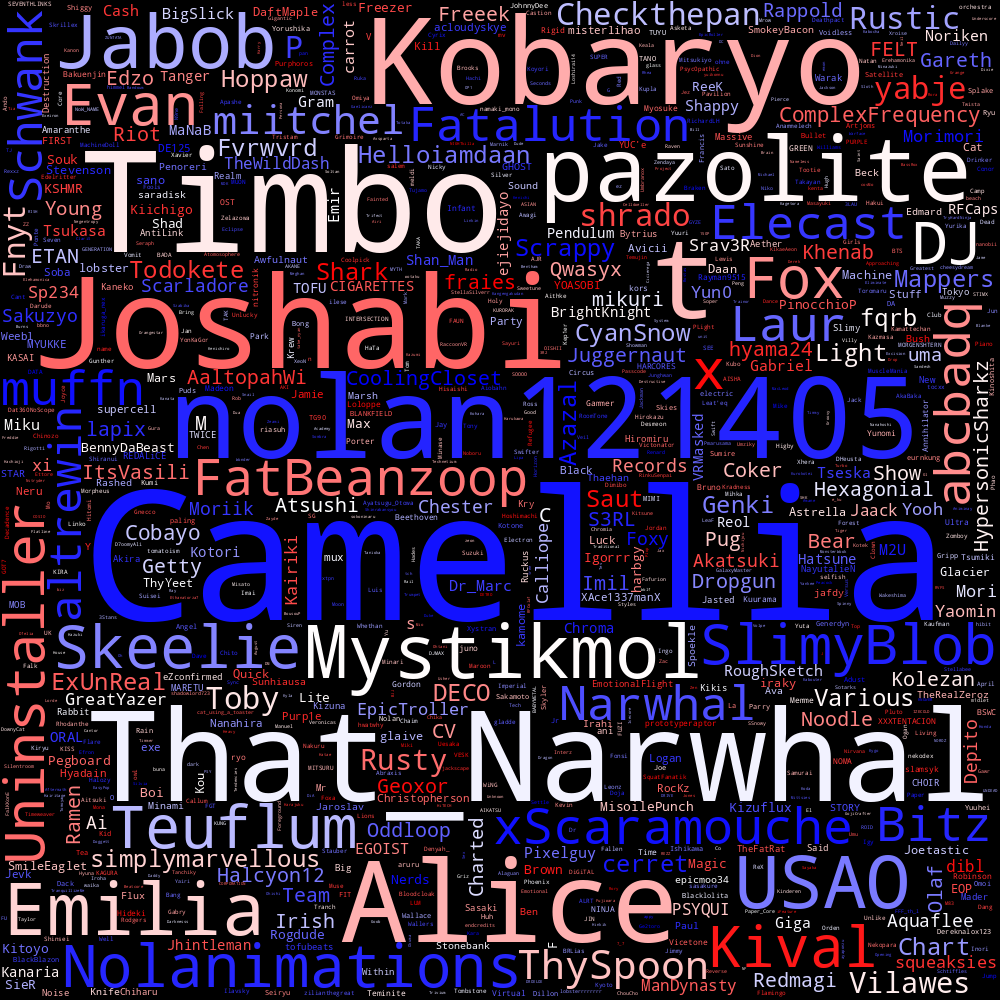

In [4]:
#@title ## MyBSCloud

#@markdown wordcloud_targetはプレイデータの何を対象にwordcloudを作成するかです。<br >　LevelAuthor:マッパー、SongAuthor:曲の作者、Song:曲名、マッパー、曲の作者<br >
#@markdown Level&SongAuthorくらいが自分のwordcloudとしては妥当なんじゃないかなと思います。<br >
#@markdown wordの出現頻度の多さでサイズが変わります。<br >
#@markdown max_wordsはワードの数の上限です。小さくすると頻度が少ないワードが消えます。<br >
#@markdown additional_stopwordsは除外したいワードです。本筋と違うけど多く出てきてしまったワードをデフォルトで設定しています。","区切りで必要に応じて追加してください<br >
#@markdown color_mapはbwrが個人的に好きです。<br >
#@markdown 全体を実行した場合、MyBSCloud(Mask)の画像アップロード待ち状態になり、処理しないと次の処理が動かなくなります。<br >
#@markdown その場合、MyBSCloud(Mask)のキャンセルを実行し、一旦処理を終えてください。<br >

#@markdown ---
#@markdown <h4>Enable</h4>
wordcloud_is_enable = True #@param {type:"boolean"}

#@markdown ---
#@markdown <h4>Setting</h4>

 
width =  1000 #@param {type:"number"}
height =  1000 #@param {type:"number"}
max_words = 1000#@param {type:"number"}
background_color = "black" #param ["black", "white"]
wordcloud_target = "Level&SongAuthor" #@param ["All(-Tags)","Level","LevelAuthor", "SongAuthor", "Level&SongAuthor", "Song", "Tags", "All"]
color_map= "bwr" #@param['inferno', 'magma', 'plasma', 'viridis','Blues', 'BuGn', 'BuPu', 'GnBu','Greens', 'Greys', 'OrRd', 'Oranges','PuBu', 'PuBuGn', 'PuRd', 'Purples','RdPu', 'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd','binary', 'gist_yarg', 'gist_gray', 'gray','bone', 'pink', 'spring', 'summer','autumn', 'winter', 'cool', 'Wistia','hot', 'afmhot', 'gist_heat', 'copper','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu','RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic','Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2','Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c','flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'gnuplot','gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv', 'gist_rainbow', 'rainbow','jet', 'nipy_spectral', 'gist_ncar']
wordcloud_style= "normal"  #param["normal","random-icon-style","original-mask"]
additional_stopwords = "feat,ft,Remix,original,TV,Size,Ver,Mix,VS,Video,Game,Movie" #@param {type:"string"}
show_title = False #param {type:"boolean"}
download_is_enable = True #@param {type:"boolean"}

#@markdown ---
#@markdown <h4>Filters</h4>

filtered_level_min = 0 #@param {type:"slider", min:0, max:15, step:1}
filtered_level_max = 15 #@param {type:"slider", min:0, max:15, step:1}
filtered_pp_min = 0 #@param {type:"slider", min:0, max:1000, step:10}
filtered_pp_max = 1000 #@param {type:"slider", min:0, max:1000, step:10}
filtered_acc_min = 0 #@param {type:"slider", min:0, max:100, step:1}
filtered_acc_max = 100 #@param {type:"slider", min:0, max:100, step:1}
filtered_latest_is_enable = False #@param {type:"boolean"}
filtered_ranked_is_enable = False #@param {type:"boolean"}
filtered_fullcombo_is_enable = False #param {type:"boolean"}

wc_icons = [
         'fas fa-bomb',
         'fas fa-caret-square-down',
         'fas fa-caret-square-left',
         'fas fa-caret-square-right',
         'fas fa-caret-square-up',
         'fas fa-certificate',
         'fas fa-clone',
         'fas fa-circle',
         'fas fa-dice-d6',
         'fas fa-dice-one',
]

def func_level_to_star(x):
    return "{}'".format(x)

def func_accrank(x):
    if x == "SS":
        return x
    if len(x) == 1:
        return x + "'"
    elif len(x) == 2:
        return x
    elif len(x) > 2:
        return "SSP'"
    return x + "'"

def func_acc_and_rank(x):
    if len(x[0]) > 2:
        return "SSP{:.0f}".format(x[1])
    else:
        return "{}{:.0f}".format(x[0], x[1])

def func_acc_to_int(x):
    return "{:.0f}'".format(x)

def create_style_wordcloud(text):
    import random
    wc_icon = random.choice(wc_icons)

    stylecloud.gen_stylecloud(text=text,
                            icon_name=wc_icon,
                            palette="cartocolors.qualitative.Bold_5",
                            background_color='black',
                            random_state=True,
                            max_words=max_words,
                            collocations = False,
                            size=(width, height)
                            )

def create_wordcloud(text):
    font_path_gothic = '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'
    wordcloud = WordCloud(background_color=background_color, max_words=max_words, 
                          width=width, height=height,
                          collocations = False, colormap=color_map
                          ).generate(text)


    # WordCloudの画像をPIL.Imageオブジェクトに変換
    wc_image = wordcloud.to_image()

    # 画像を保存
    output_filename = "MyBSCloud_{}_{}.png".format(tz_ja.strftime("%Y%m%d_%H%M%S"), df_info["name"][0])

    wc_image.save(output_filename)

    # 画像をダウンロード
    if download_is_enable:
        files.download(output_filename)

    # PIL.Imageオブジェクトを表示
    wc_image.show()

# colormap参考記事
# https://karupoimou.hatenablog.com/entry/2019/05/17/153207

df_wordcloud = df_scores.copy()

if filtered_latest_is_enable:
    df_wordcloud = df_wordcloud[(df_wordcloud["Latest"] == 1)]

if filtered_ranked_is_enable:
    df_wordcloud = df_wordcloud[(df_wordcloud['Ranked']==1)]
    df_wordcloud = df_wordcloud[(1==1)
        & (df_wordcloud["Stars"] >= filtered_level_min)
        & (df_wordcloud["Stars"] < filtered_level_max)
        & (df_wordcloud["PP"] >= filtered_pp_min)
        & (df_wordcloud["PP"] < filtered_pp_max)
        & (df_wordcloud["Acc"] >= filtered_acc_min)
        & (df_wordcloud["Acc"] <= filtered_acc_max)]

if filtered_fullcombo_is_enable:
    df_wordcloud = df_wordcloud[(df_wordcloud['FC']=="FC")]

df_wordcloud['LevelStr'] = df_wordcloud['LevelStr'].apply(func_level_to_star)

df_wordcloud['AccRank'] = df_wordcloud['AccRank'].apply(func_accrank)


if len(df_wordcloud) > 0 and wordcloud_is_enable:


    try:
        from wordcloud import WordCloud, STOPWORDS
        import stylecloud
    except ImportError:
        !pip install japanize-matplotlib
        !pip install stylecloud
        from wordcloud import WordCloud, STOPWORDS
        import stylecloud


    # 既存のストップワードに追加するストップワードをカンマで分割
    additional_stopwords_list = additional_stopwords.split(',')

    # ストップワードを追加
    for word in additional_stopwords_list:
        stripped_word = word.strip()
        if stripped_word:  # 空の文字列でない場合にのみ追加
            STOPWORDS.add(stripped_word)

    def get_wordcloud_text(wordcloud_target):
        if wordcloud_target == "LevelAuthor":
            list_levelauthor = df_wordcloud["LevelAuthor"].tolist()
            wc_text = " ".join(list_levelauthor)
        elif wordcloud_target == "SongAuthor":
            list_songauthor = df_wordcloud["SongAuthor"].tolist()
            wc_text = " ".join(list_songauthor)
        elif wordcloud_target == "Level&SongAuthor":
            list_levelauthor = df_wordcloud["LevelAuthor"].tolist()
            list_songauthor = df_wordcloud["SongAuthor"].tolist()
            list_merge = copy.copy(list_songauthor)
            list_merge.extend(list_levelauthor)
            wc_text = " ".join(list_merge)
        elif wordcloud_target == "Tags":
            list_tags = df_wordcloud["Tags"].dropna().tolist()
            wc_text = " ".join(list_tags)
        elif wordcloud_target == "Song":
            list_song = df_wordcloud["Song"].tolist()
            wc_text = " ".join(list_song)

        elif wordcloud_target == "Level":
            list_acc = df_wordcloud["AccRank"].dropna().tolist()
            list_level = df_wordcloud["LevelStr"].dropna().tolist()
            list_merge = copy.copy(list_acc)
            list_merge.extend(list_level)
            wc_text = " ".join(list_merge)

        elif (wordcloud_target == "All") or (wordcloud_target == "All(-Tags)"):
            list_song = df_wordcloud["Song"].tolist()

            list_acc = df_wordcloud["AccRank"].dropna().tolist()
            #list_acc = df_wordcloud["Acc"].dropna().tolist()
            list_level = df_wordcloud["LevelStr"].dropna().tolist()
            list_merge = copy.copy(list_song)
            if wordcloud_target == "All":
                list_tags = df_wordcloud["Tags"].dropna().tolist()
                list_merge.extend(list_tags)
            list_merge.extend(list_acc)
            list_merge.extend(list_level)
            wc_text = " ".join(list_merge)
        return wc_text

    # wordcloud_targets = ["LevelAuthor","SongAuthor","Level&SongAuthor"]
    wordcloud_targets = ["Level&SongAuthor"]

    wc_text = get_wordcloud_text(wordcloud_target)

    # ワードクラウドの作成
    if wordcloud_style == "random-icon-style":
        create_style_wordcloud(wc_text)
        from IPython.display import Image
        display(Image(filename="./stylecloud.png", width=width, height=height))
    else:
        create_wordcloud(wc_text)
else:
    print("データ件数が0件または フラグが無効のため WordCloud が作成できません。作成する場合は条件を見直してください。")


<IPython.core.display.Javascript object>

マスク画像ファイルをアップロードしてください（キャンセルで前回のファイルを使用）:


前回アップロードされたファイル 'face_mask33.png' を使用します。


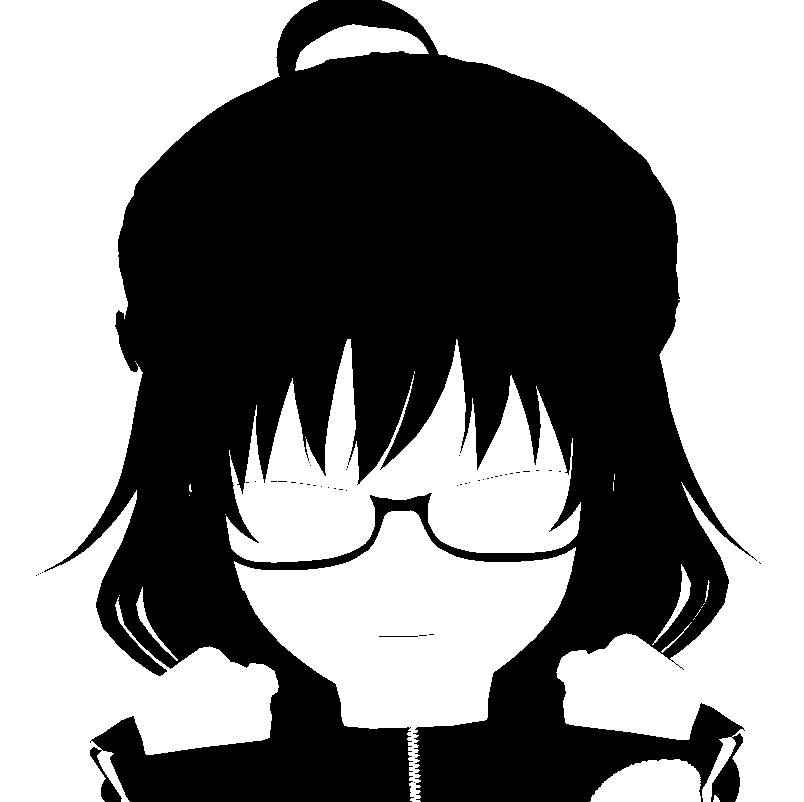

(802, 804, 4)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

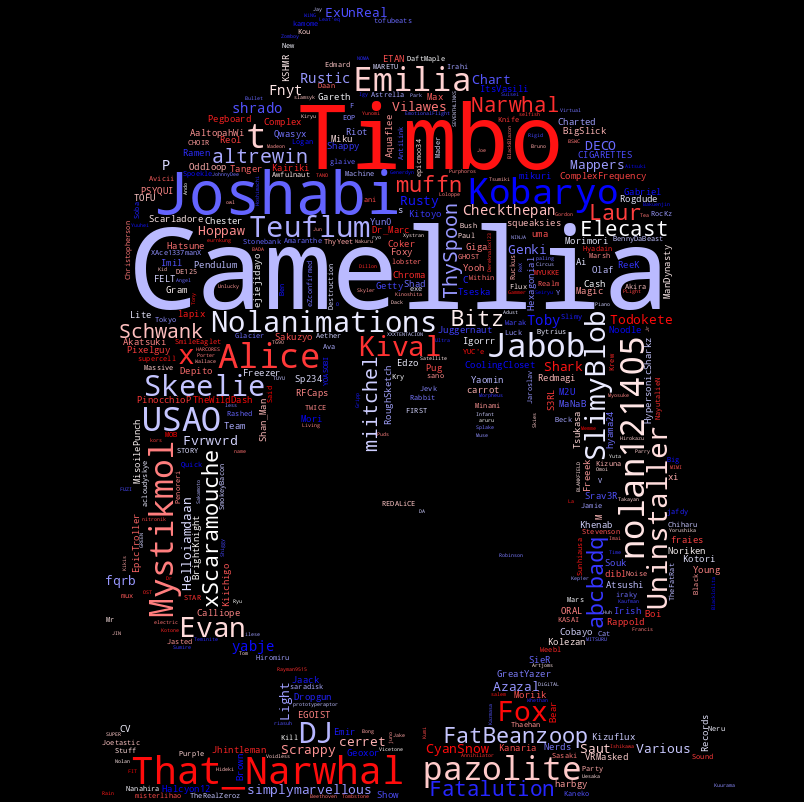

(802, 804, 4)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

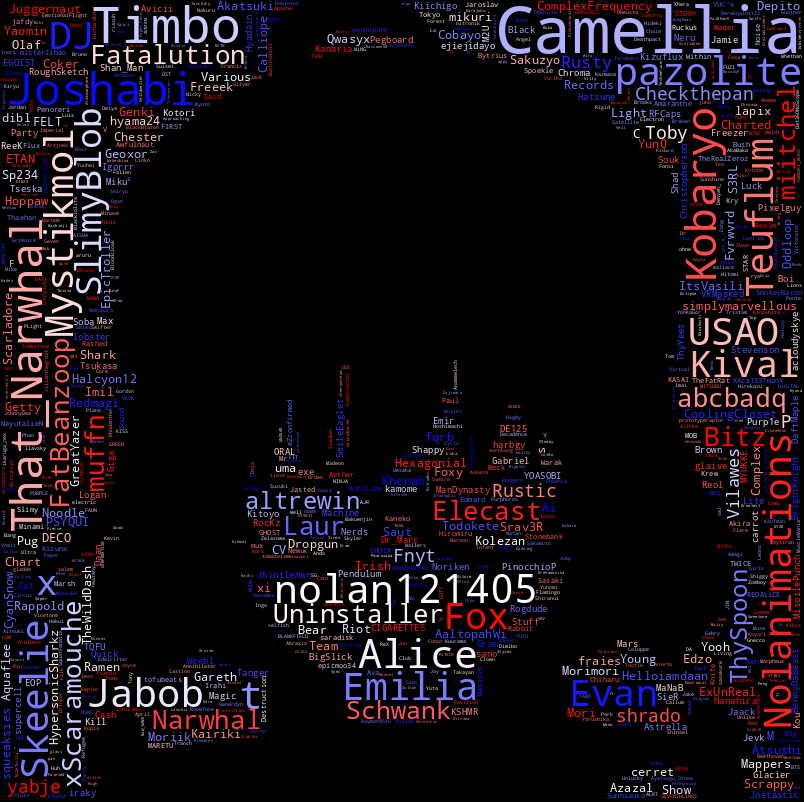

In [10]:
#@title ## MyBSCloud(Mask)

#@markdown ※ mask画像のアップロードが必要です。2回目以降キャンセルを押すと前回のmask画像を流用します。<br >
#@markdown 　mask画像は完全な白と黒の画像をアップしてください。マスク画像の黒の部分にwordを出現させます。<br >
#@markdown 　mask画像は白黒ですが、画像はRGBまたはRGBAの形式にしてください。<br >
#@markdown 　mask画像はbinarize_is_enableを有効にすると2値化(白と黒にする)を実行してRGBA形式のマスク画像にしますが、質が低いです。<br >
#@markdown 　thresholdで2値化の閾値を変更可能にしていますが、あまり期待しないでください。(自動でセグメンテーションもためしましたが質が低かったです。<br >
#@markdown 　2値化に背景透過画像を入力として用いる場合、透過部が黒として扱われてしまうので注意してください。<br >
#@markdown 　invert_maskを有効にすると白黒反転した場合の画像も合わせて出力します。<br >
#@markdown 　アップロードしたmask画像や出力画像は一時的にcolab上に保存されますがアップロードされますが、セッションを閉じると破棄されます。<br >
#@markdown 　出力画像サイズはmask画像のサイズにup_scaleの倍率をかけたサイズで出力します。<br >
#@markdown 　画像処理の時間は当たり前ですが、処理サイズに応じて大きくなるので注意してください。<br >
#@markdown 　キャンセルを押すと前回のmask画像を流用します。<br >
#@markdown 　全体を実行した場合など、MyBSCloud(Mask)の画像アップロード待ち状態になり、処理しないと次の処理が動かなくなってる事があります。<br >
#@markdown 　その場合、MyBSCloud(Mask)のキャンセルを実行し、一旦処理を終えてください。<br >

#@markdown ---
#@markdown <h4>Enable</h4>
wordcloud_masked_is_enable = True #@param {type:"boolean"}

#@markdown ---
#@markdown <h4>Setting</h4>


# width =  1000 #@param {type:"number"}
# height =  1000 #@param {type:"number"}
max_words =  1000#@param {type:"number"}
background_color = "black" #param ["black", "white"]
wordcloud_target = "Level&SongAuthor" #@param ["All(-Tags)","Level","LevelAuthor", "SongAuthor", "Level&SongAuthor", "Song", "Tags", "All"]
color_map= "bwr" #@param['inferno', 'magma', 'plasma', 'viridis','Blues', 'BuGn', 'BuPu', 'GnBu','Greens', 'Greys', 'OrRd', 'Oranges','PuBu', 'PuBuGn', 'PuRd', 'Purples','RdPu', 'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd','binary', 'gist_yarg', 'gist_gray', 'gray','bone', 'pink', 'spring', 'summer','autumn', 'winter', 'cool', 'Wistia','hot', 'afmhot', 'gist_heat', 'copper','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu','RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic','Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2','Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c','flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'gnuplot','gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv', 'gist_rainbow', 'rainbow','jet', 'nipy_spectral', 'gist_ncar']
wordcloud_style= "original-mask"  #param["normal","random-icon-style","original-mask"]
additional_stopwords = "feat,ft,Remix,original,TV,Size,Ver,Mix,VS,Video,Game,Movie" #@param {type:"string"}
mask_file_name = "mask.png" #param ["mask.png", "mask_face.png"] {allow-input: true}
show_title = False #param {type:"boolean"}
up_scale = 1 #@param {type:"slider", min:0.25, max:4, step:0.25}
#@title マスク画像の白黒反転
invert_mask = True #@param {type:"boolean"}
download_is_enable = True #@param {type:"boolean"}
binarize_is_enable = True #@param {type:"boolean"}
binarize_threshold =29 #@param {type:"slider", min:1, max:254, step:1}

#@markdown ---
#@markdown <h4>Filters</h4>

filtered_level_min = 0 #@param {type:"slider", min:0, max:15, step:1}
filtered_level_max = 15 #@param {type:"slider", min:0, max:15, step:1}
filtered_pp_min = 0 #@param {type:"slider", min:0, max:1000, step:10}
filtered_pp_max = 1000 #@param {type:"slider", min:0, max:1000, step:10}
filtered_acc_min = 0 #@param {type:"slider", min:0, max:100, step:1}
filtered_acc_max = 100 #@param {type:"slider", min:0, max:100, step:1}
filtered_latest_is_enable = False #@param {type:"boolean"}
filtered_ranked_is_enable = False #@param {type:"boolean"}
filtered_fullcombo_is_enable = False #param {type:"boolean"}

wc_icons = [
         'fas fa-bomb',
         'fas fa-caret-square-down',
         'fas fa-caret-square-left',
         'fas fa-caret-square-right',
         'fas fa-caret-square-up',
         'fas fa-certificate',
         'fas fa-clone',
         'fas fa-circle',
         'fas fa-dice-d6',
         'fas fa-dice-one',
]

def func_level_to_star(x):
    return "{}'".format(x)

def func_accrank(x):
    if x == "SS":
        return x
    if len(x) == 1:
        return x + "'"
    elif len(x) == 2:
        return x
    elif len(x) > 2:
        return "SSP'"
    return x + "'"

def func_acc_and_rank(x):
    if len(x[0]) > 2:
        return "SSP{:.0f}".format(x[1])
    else:
        return "{}{:.0f}".format(x[0], x[1])

def func_acc_to_int(x):
    return "{:.0f}'".format(x)

def create_wordcloud_original_mask(text, img_path, invert_mask=False):
    font_path_gothic = '/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'
    img = Image.open(img_path)
    width, height = img.size
    width, height =  math.floor(width * up_scale),  math.floor(height * up_scale)
    img_resized = img.resize((width, height))  # 画像をリサイズ
    img_color = np.array(img_resized)  # リサイズされた画像を配列に変換

    # フラグがTrueの場合、マスク画像の色を反転
    if invert_mask:
        img_color = np.invert(img_color)

    print(img_color.shape)

    

    wordcloud = WordCloud(background_color=background_color,
                max_words=max_words, 
                width=width, height=height,
                #    font_path=font_path_gothic,
                max_font_size=200,  # 最大フォントサイズを設定
                mask=img_color,
                collocations=False, # 単語の重複しないように
                colormap=color_map
                ).generate( text )


    # WordCloudの画像をPIL.Imageオブジェクトに変換
    wc_image = wordcloud.to_image()

    # 画像を保存
    if invert_mask:
        output_filename = "MyBSCloud_mask_{}_{}.png".format(tz_ja.strftime("%Y%m%d_%H%M%S"), df_info["name"][0])
    else:
        output_filename = "MyBSCloud_mask_inv_{}_{}.png".format(tz_ja.strftime("%Y%m%d_%H%M%S"), df_info["name"][0])

    wc_image.save(output_filename)

    # 画像をダウンロード
    if download_is_enable:
        files.download(output_filename)

    # PIL.Imageオブジェクトを表示
    wc_image.show()


def binarize_image(img, threshold=128):
    # 画像をグレースケールに変換
    img_gray = img.convert('L')
    # 2値化処理
    img_binary = img_gray.point(lambda x: 0 if x < threshold else 255, '1')
    return img_binary

def create_binarize_image(img_path):
    img = Image.open(img_path)

    # 2値化処理
    img_binary = binarize_image(img)

    # 画像をRGBAに変換
    rgba_img = img_binary.convert('RGBA')

    # RGBA画像を保存
    rgba_img.save('rgba_image.png')

    # PIL.Imageオブジェクトを表示
    rgba_img.show()
    mask_image_path = "rgba_image.png"

    return mask_image_path

# colormap参考記事
# https://karupoimou.hatenablog.com/entry/2019/05/17/153207

df_wordcloud = df_scores.copy()

if filtered_latest_is_enable:
    df_wordcloud = df_wordcloud[(df_wordcloud["Latest"] == 1)]

if filtered_ranked_is_enable:
    df_wordcloud = df_wordcloud[(df_wordcloud['Ranked']==1)]
    df_wordcloud = df_wordcloud[(1==1)
        & (df_wordcloud["Stars"] >= filtered_level_min)
        & (df_wordcloud["Stars"] < filtered_level_max)
        & (df_wordcloud["PP"] >= filtered_pp_min)
        & (df_wordcloud["PP"] < filtered_pp_max)
        & (df_wordcloud["Acc"] >= filtered_acc_min)
        & (df_wordcloud["Acc"] <= filtered_acc_max)]

if filtered_fullcombo_is_enable:
    df_wordcloud = df_wordcloud[(df_wordcloud['FC']=="FC")]

df_wordcloud['LevelStr'] = df_wordcloud['LevelStr'].apply(func_level_to_star)

df_wordcloud['AccRank'] = df_wordcloud['AccRank'].apply(func_accrank)


if len(df_wordcloud) > 0 and wordcloud_masked_is_enable:


    try:
        from wordcloud import WordCloud, STOPWORDS
        import stylecloud
    except ImportError:
        !pip install japanize-matplotlib
        !pip install stylecloud
        from wordcloud import WordCloud, STOPWORDS
        import stylecloud


    # 既存のストップワードに追加するストップワードをカンマで分割
    additional_stopwords_list = additional_stopwords.split(',')

    # ストップワードを追加
    for word in additional_stopwords_list:
        stripped_word = word.strip()
        if stripped_word:  # 空の文字列でない場合にのみ追加
            STOPWORDS.add(stripped_word)

    def get_wordcloud_text(wordcloud_target):
        if wordcloud_target == "LevelAuthor":
            list_levelauthor = df_wordcloud["LevelAuthor"].tolist()
            wc_text = " ".join(list_levelauthor)
        elif wordcloud_target == "SongAuthor":
            list_songauthor = df_wordcloud["SongAuthor"].tolist()
            wc_text = " ".join(list_songauthor)
        elif wordcloud_target == "Level&SongAuthor":
            list_levelauthor = df_wordcloud["LevelAuthor"].tolist()
            list_songauthor = df_wordcloud["SongAuthor"].tolist()
            list_merge = copy.copy(list_songauthor)
            list_merge.extend(list_levelauthor)
            wc_text = " ".join(list_merge)
        elif wordcloud_target == "Tags":
            list_tags = df_wordcloud["Tags"].dropna().tolist()
            wc_text = " ".join(list_tags)
        elif wordcloud_target == "Song":
            list_song = df_wordcloud["Song"].tolist()
            wc_text = " ".join(list_song)

        elif wordcloud_target == "Level":
            list_acc = df_wordcloud["AccRank"].dropna().tolist()
            list_level = df_wordcloud["LevelStr"].dropna().tolist()
            list_merge = copy.copy(list_acc)
            list_merge.extend(list_level)
            wc_text = " ".join(list_merge)

        elif (wordcloud_target == "All") or (wordcloud_target == "All(-Tags)"):
            list_song = df_wordcloud["Song"].tolist()

            list_acc = df_wordcloud["AccRank"].dropna().tolist()
            #list_acc = df_wordcloud["Acc"].dropna().tolist()
            list_level = df_wordcloud["LevelStr"].dropna().tolist()
            list_merge = copy.copy(list_song)
            if wordcloud_target == "All":
                list_tags = df_wordcloud["Tags"].dropna().tolist()
                list_merge.extend(list_tags)
            list_merge.extend(list_acc)
            list_merge.extend(list_level)
            wc_text = " ".join(list_merge)
        return wc_text

    wc_text = get_wordcloud_text(wordcloud_target)

    print("マスク画像ファイルをアップロードしてください（キャンセルで前回のファイルを使用）:")
    from google.colab import files

    # previous_uploaded_file = None
    uploaded = files.upload()

    if not uploaded:  # アップロードがキャンセルされた場合
        if previous_uploaded_file is not None:
            print(f"前回アップロードされたファイル '{previous_uploaded_file}' を使用します。")
            if binarize_is_enable:
                binarized_file = create_binarize_image(previous_uploaded_file)
                create_wordcloud_original_mask(wc_text, binarized_file, False)
                if invert_mask:
                    create_wordcloud_original_mask(wc_text, binarized_file, True)
            else:
                create_wordcloud_original_mask(wc_text, previous_uploaded_file, False)
                if invert_mask:
                    create_wordcloud_original_mask(wc_text, previous_uploaded_file, True)
        else:
            print("アップロードがキャンセルされました。")
    else:  # アップロードが成功した場合
        file_name = next(iter(uploaded))

        previous_uploaded_file = file_name
        # 既存のファイルがある場合は削除
        if os.path.exists(file_name):
            os.remove(file_name)           
        # アップロードされたファイルを保存
        with open(file_name, 'wb') as f:
            f.write(uploaded[file_name])
        print(f"アップロードされたファイル名: {file_name}")

        if binarize_is_enable:
            file_name_path = create_binarize_image(file_name)

        create_wordcloud_original_mask(wc_text, file_name, False)
        if invert_mask:
            create_wordcloud_original_mask(wc_text, file_name, True)
else:
    print("データ件数が0件または フラグが無効のため WordCloud が作成できません。作成する場合は条件を見直してください。")
